Необходимо решить задачу кластеризации для тех данных, для которых ранее решалась задача классификации. Будут использованы следующие методы:



Импортируем библиотеки, которые понадобятся нам далее

In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Загружаем датасет

In [ ]:
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
csv_file = "melb_data.csv"
df = pd.read_csv(os.path.join(path, csv_file))

100%|██████████| 451k/451k [00:00<00:00, 1.12MB/s]

Extracting files...


Далее будет повторена вся предобработка, как и в прошлом домашнем задании, за исключением того факта, что теперь разделение на тренировочную и тестовую выборки теперь не требуется.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #переводим дату в соответствующий формат

In [ ]:
parts = df['Address'].str.split() # разделяем адрес на составные части
df['house_number'] = parts.str[0]
df['street_type'] = parts.str[-1]
df['street_name'] = parts.str[1:-1].str.join(' ')
df = df.drop(columns=['Address'])

In [ ]:
df = df.drop(columns=['street_name','house_number']) #удаляем ненужные признаки

In [ ]:
mapping = {
    #Проспект
    'Av': 'Avenue',
    'Ave': 'Avenue',

    #Роща
    'Gr': 'Grove',
    'Gra': 'Grove',

    #Стороны света
    'N': 'North',
    'S': 'South',
    'W': 'West',
    'E': 'East',

    #Шоссе
    'Hwy': 'Highway',

    #Бульвар
    'Bvd': 'Boulevard',

    #Набережная
    'Esp': 'Esplanade',

    #Парк
    'Pde': 'Parade',
}


df['street_type'] = df['street_type'].replace(mapping) #объединяем уникальные значения признаков по смыслу

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']

Далее объединяем редкие значения признаков в один

In [ ]:
threshold = 60
value_counts = X['Suburb'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['Suburb'] = X['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)


In [ ]:
threshold = 30
value_counts = X['SellerG'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['SellerG'] = X['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)


In [ ]:
threshold = 50
value_counts = X['CouncilArea'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['CouncilArea'] = X['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [ ]:
threshold = 40
value_counts = X['Regionname'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['Regionname'] = X['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [ ]:
threshold1 = 100
value_counts1 = X['street_type'].value_counts()
frequent_values1 = value_counts1[value_counts1 >= threshold].index
allowed_values1 = set(frequent_values1)

X['street_type'] = X['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

Переводим признаки в категориальные

In [ ]:
X['Suburb'] = X['Suburb'].astype('category')

X['street_type'] = X['street_type'].astype('category')

X['SellerG'] = X['SellerG'].astype('category')

X['CouncilArea'] = X['CouncilArea'].astype('category')

X['Regionname'] = X['Regionname'].astype('category')

X['Type'] = X['Type'].astype('category')

X['Method'] = X['Method'].astype('category')

Обработка числовых признаков:

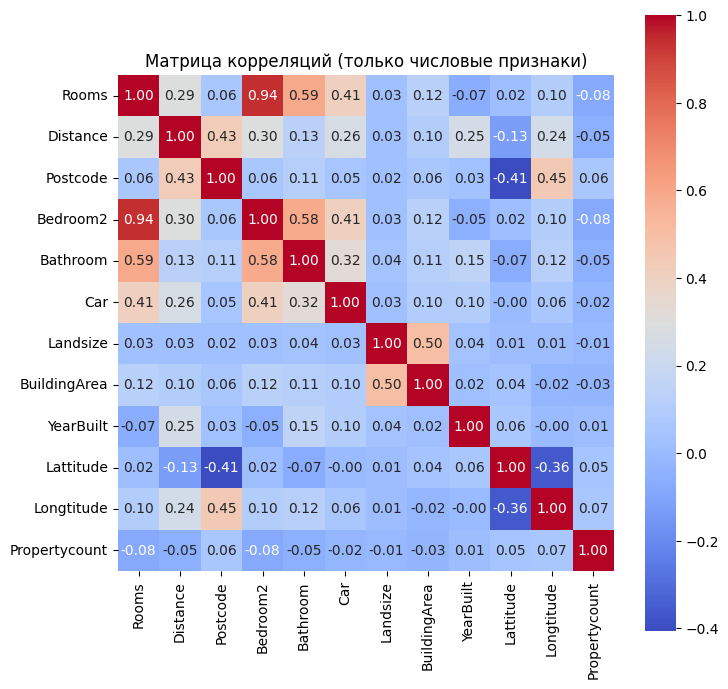

In [ ]:
df = X.copy()
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки)')
plt.show()

In [ ]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Rooms     Bedroom2        0.944190
          Bathroom        0.592934
Bedroom2  Bathroom        0.584685
Landsize  BuildingArea    0.500485
dtype: float64

In [ ]:
X = X.assign(TotalRooms = X['Rooms'] + X['Bathroom']) #два коррелирующих признака объединили в один

In [ ]:
X = X.drop('Bedroom2', axis=1)
X = X.drop('Rooms', axis=1)
X = X.drop('Bathroom', axis=1)

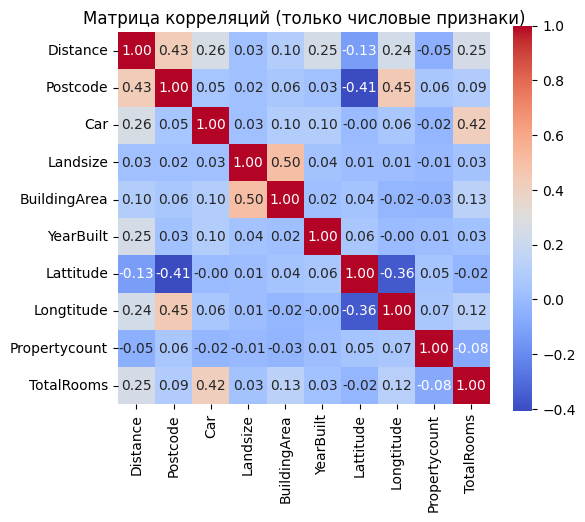

In [ ]:
train_df = X.copy()
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки)')
plt.show()

In [ ]:
X = X.assign(TotalArea = X['Landsize'] + X['BuildingArea']) #два коррелирующих признака объединили в один
X = X.drop('BuildingArea', axis=1)
X = X.drop('Landsize', axis=1)

обрабатываем выбросы

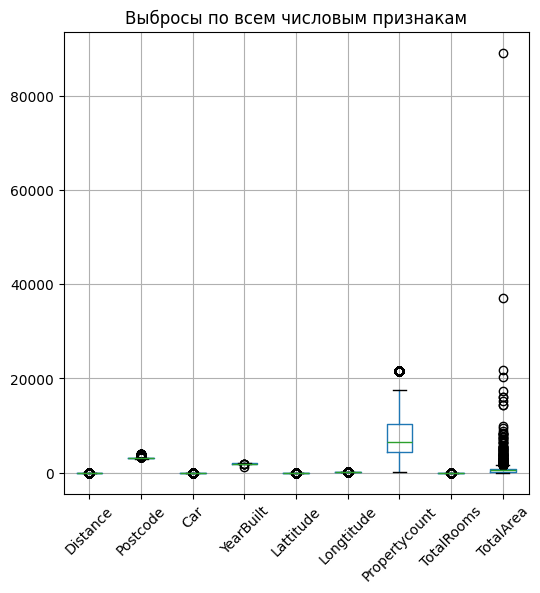

In [ ]:
numeric_cols = X.select_dtypes(include=['number']).columns

plt.figure(figsize=(6, 6))
X[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

In [ ]:
rows_to_drop = X[
    (X['TotalArea']  < X['TotalArea' ].quantile(0.005)) | (X['TotalArea']  > X['TotalArea' ].quantile(0.995))|
    (X['Propertycount']  < X['Propertycount' ].quantile(0.005)) | (X['Propertycount']  > X['Propertycount' ].quantile(0.995))].index

In [ ]:
X = X.drop(rows_to_drop)
y = y.drop(rows_to_drop)

обрабатываем пропущенные значения

In [ ]:
numeric_cols = X.select_dtypes(include=['number']).columns

numeric_medians = X[numeric_cols].median()
X[numeric_cols] = X[numeric_cols].fillna(numeric_medians)

кодируем категориальные признаки

In [ ]:
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()

ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False)

ohe.fit(X[categorical_columns])

X_cat_ohe = ohe.transform(X[categorical_columns])

ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

X_cat_df = pd.DataFrame(X_cat_ohe, columns=ohe_feature_names, index=X.index)

numerical_columns = [col for col in X.columns if col not in categorical_columns]

X = pd.concat([X[numerical_columns], X_cat_df], axis=1)

переводим дату в количество дней от минимальной даты

In [ ]:
min_date = X['Date'].min()

X['DaysSinceStart'] = (X['Date'] - min_date).dt.days

X = X.drop('Date', axis=1)

нормализуем числовые признаки

In [ ]:
numerical_columns = ['Postcode','TotalRooms', 'Distance', 'Car',
                     'TotalArea', 'YearBuilt', 'Lattitude', 'Longtitude',
                     'DaysSinceStart', 'Propertycount']

scaler = StandardScaler()

X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

Теперь начнем решать задачу кластеризации

Понизим размерность с помощью PCA

In [ ]:
from sklearn.decomposition import PCA

Сначала посмотрим, что будет, если понизить размерность до двух компонент

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Объясненная дисперсия 2 компонент: {sum(pca.explained_variance_ratio_):.2%}")

Объясненная дисперсия 2 компонент: 28.32%


**1. KMeans**

In [ ]:
from sklearn.cluster import KMeans

Для подбора k - количества класса попробуем использовать метод локтя

In [ ]:
max_k=30
k_range = range(1, max_k + 1)
inertia = []
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

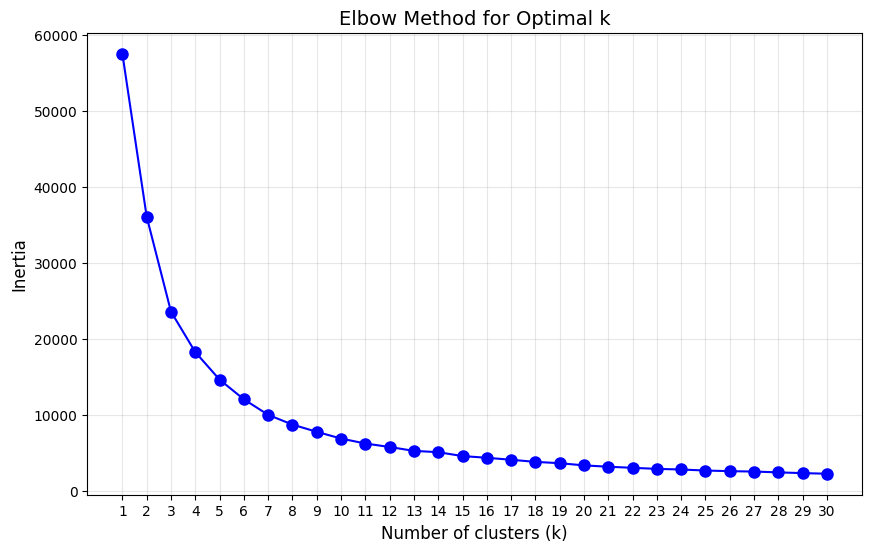

In [ ]:
# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

Судя по графику метод не дал очевидного ответа какое k оптимальное, поэтому попробуем другие методы выбора k: коэффициент силуэта, индекс Калинского-Харабаса, индекс Дэвиса-Болдина.

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

scores = {'silhouette': [], 'calinski': [], 'davies': []}
k_range = range(2, max_k)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    if len(set(labels)) > 1:  # нужно больше 1 кластера
        scores['silhouette'].append(silhouette_score(X_pca, labels))
        scores['calinski'].append(calinski_harabasz_score(X_pca, labels))
        scores['davies'].append(davies_bouldin_score(X_pca, labels))

# Оптимальные k по разным метрикам
optimal_k = {
    'silhouette': k_range[np.argmax(scores['silhouette'])],
    'calinski': k_range[np.argmax(scores['calinski'])],
    'davies': k_range[np.argmin(scores['davies'])]
}

In [ ]:
print(optimal_k)

{'silhouette': 3, 'calinski': 24, 'davies': 8}


Попробуем использовать 3 класса, 8, а потом 24





In [ ]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans_labels3 = kmeans3.fit_predict(X_pca)

In [ ]:
kmeans8 = KMeans(n_clusters=8, random_state=42)
kmeans_labels8 = kmeans8.fit_predict(X_pca)

In [ ]:
kmeans24 = KMeans(n_clusters=24, random_state=42)
kmeans_labels24 = kmeans24.fit_predict(X_pca)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

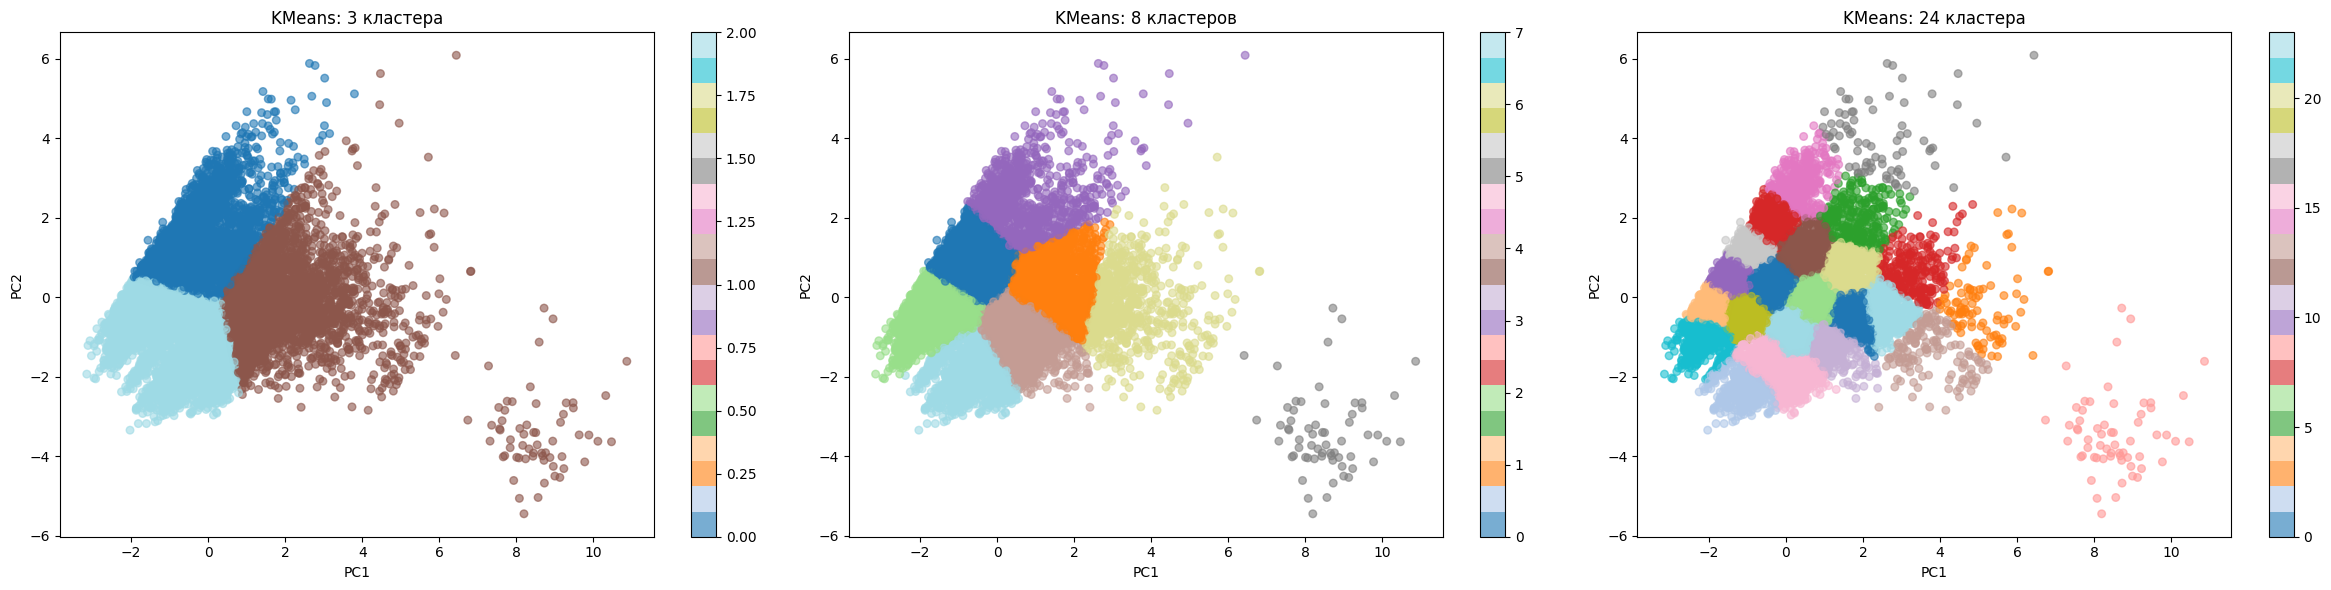

=== Анализ кластеризации ===
KMeans (k=3):
  - Число кластеров: 3
  - Размеры кластеров: [4494 3773 5180]
  - Доля объектов: [0.33420094 0.28058303 0.38521603]

KMeans (k=8):
  - Число кластеров: 8
  - Размеры кластеров: [3233 1770 2667 1233 2112   62  750 1620]
  - Минимальный размер: 62
  - Максимальный размер: 3233

KMeans (k=24):
  - Число кластеров: 24
  - Размеры кластеров: [ 710  682  588   96  851  286  660  835  273   61 1117  683  522  148
  429  716  492   78 1190  722  514  685  693  416]
  - Минимальный размер: 61
  - Максимальный размер: 1190


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels3,
                          cmap='tab20', alpha=0.6, s=30)
axes[0].set_title('KMeans: 3 кластера')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels8,
                          cmap='tab20', alpha=0.6, s=30)
axes[1].set_title('KMeans: 8 кластеров')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1])

scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels24,
                          cmap='tab20', alpha=0.6, s=30)
axes[2].set_title('KMeans: 24 кластера')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

print("=== Анализ кластеризации ===")
print(f"KMeans (k=3):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels3))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels3)}")
print(f"  - Доля объектов: {np.bincount(kmeans_labels3) / len(kmeans_labels3)}")

print(f"\nKMeans (k=8):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels8))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels8)}")
print(f"  - Минимальный размер: {np.min(np.bincount(kmeans_labels8))}")
print(f"  - Максимальный размер: {np.max(np.bincount(kmeans_labels8))}")

print(f"\nKMeans (k=24):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels24))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels24)}")
print(f"  - Минимальный размер: {np.min(np.bincount(kmeans_labels24))}")
print(f"  - Максимальный размер: {np.max(np.bincount(kmeans_labels24))}")



Все три варианта дали не очень хорошие результаты.

2. **DBSCAN**

Text(0.5, 1.0, 'Метод локтя для подбора eps в DBSCAN')

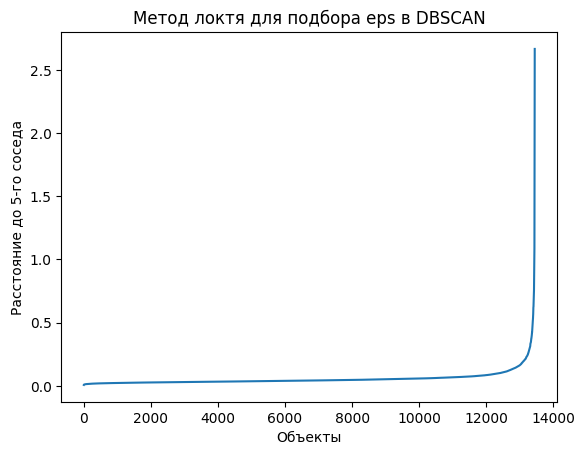

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Автоподбор eps (метод k-distance)
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_pca)
distances, indices = nn.kneighbors(X_pca)
distances = np.sort(distances[:, 4], axis=0)

# Визуализация для выбора eps
plt.plot(distances)
plt.xlabel('Объекты')
plt.ylabel('Расстояние до 5-го соседа')
plt.title('Метод локтя для подбора eps в DBSCAN')


=== Анализ DBSCAN кластеризации ===
Найдено кластеров: 10
Шумовые точки: 209 (1.6%)
Уникальные метки: [-1  0  1  2  3  4  5  6  7  8  9]
Размеры кластеров:
  Кластер 0: 13168 точек
  Кластер 1: 13 точек
  Кластер 2: 15 точек
  Кластер 3: 10 точек
  Кластер 4: 5 точек
  Кластер 5: 5 точек
  Кластер 6: 4 точек
  Кластер 7: 8 точек
  Кластер 8: 5 точек
  Кластер 9: 5 точек


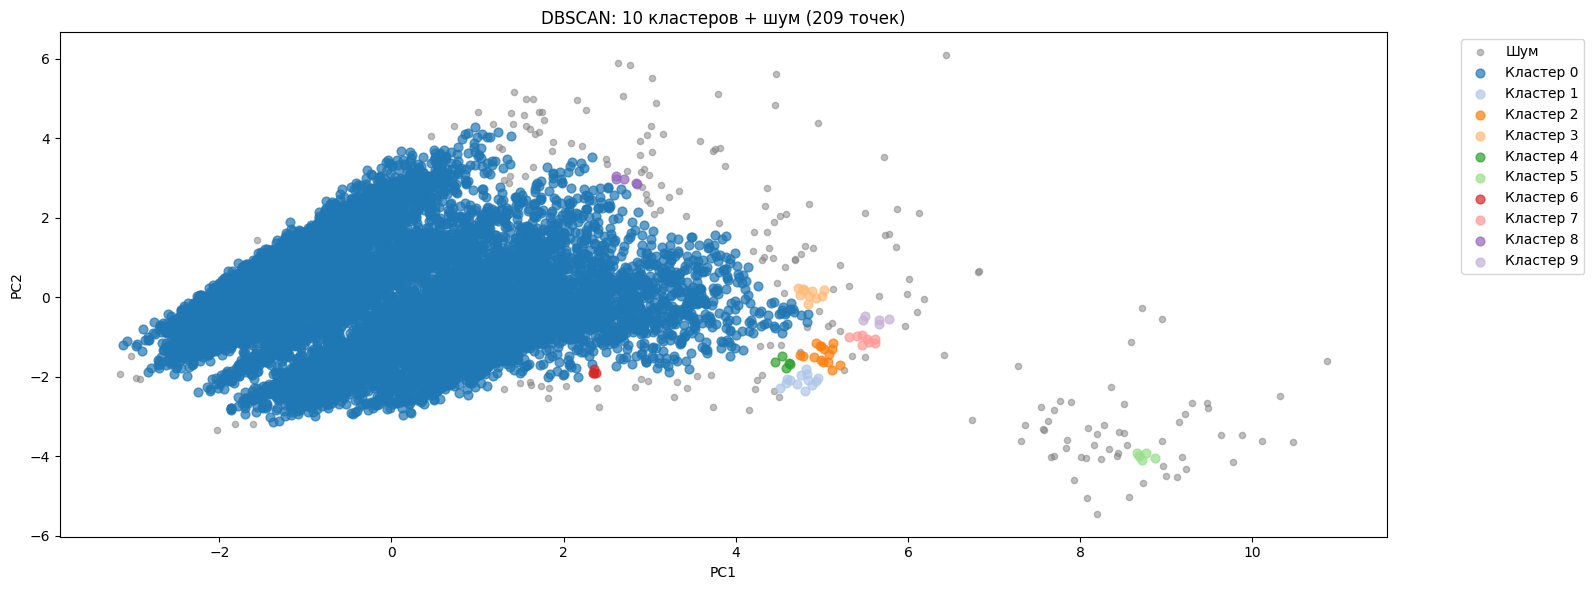

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Кластеризация DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Анализ результатов DBSCAN
print("=== Анализ DBSCAN кластеризации ===")
unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Найдено кластеров: {n_clusters}")
print(f"Шумовые точки: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"Уникальные метки: {unique_labels}")
print(f"Размеры кластеров:")
for label in unique_labels:
    if label != -1:
        print(f"  Кластер {label}: {np.sum(dbscan_labels == label)} точек")

fig, ax = plt.subplots(figsize=(16, 6))

cmap = plt.cm.tab20

if -1 in unique_labels:
    noise_mask = dbscan_labels == -1
    ax.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
               c='gray', alpha=0.5, s=20, label='Шум')

for label in unique_labels:
    if label != -1:
        mask = dbscan_labels == label
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=[cmap(label % 20)], alpha=0.7, s=40,
                   label=f'Кластер {label}')

ax.set_title(f'DBSCAN: {n_clusters} кластеров + шум ({n_noise} точек)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Результат получился еще хуже, чем в методе локтя

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
agglo_labels = agglo.fit_predict(X_pca)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglo11 = AgglomerativeClustering(n_clusters=11, linkage='ward')
agglo_label11s = agglo11.fit_predict(X_pca)

=== Анализ Agglomerative Clustering ===
Кластеризация с 3 кластерами:
  - Уникальные метки: [0 1 2]
  - Размеры кластеров: [5910 3934 3603]
  - Доли: [0.43950323 0.29255596 0.2679408 ]

Кластеризация с 8 кластерами:
  - Уникальные метки: [ 0  1  2  3  4  5  6  7  8  9 10]
  - Размеры кластеров: [1632 1017 1851 1971 2040 1455   60 1187  302 1228  704]
  - Минимальный размер: 60
  - Максимальный размер: 2040


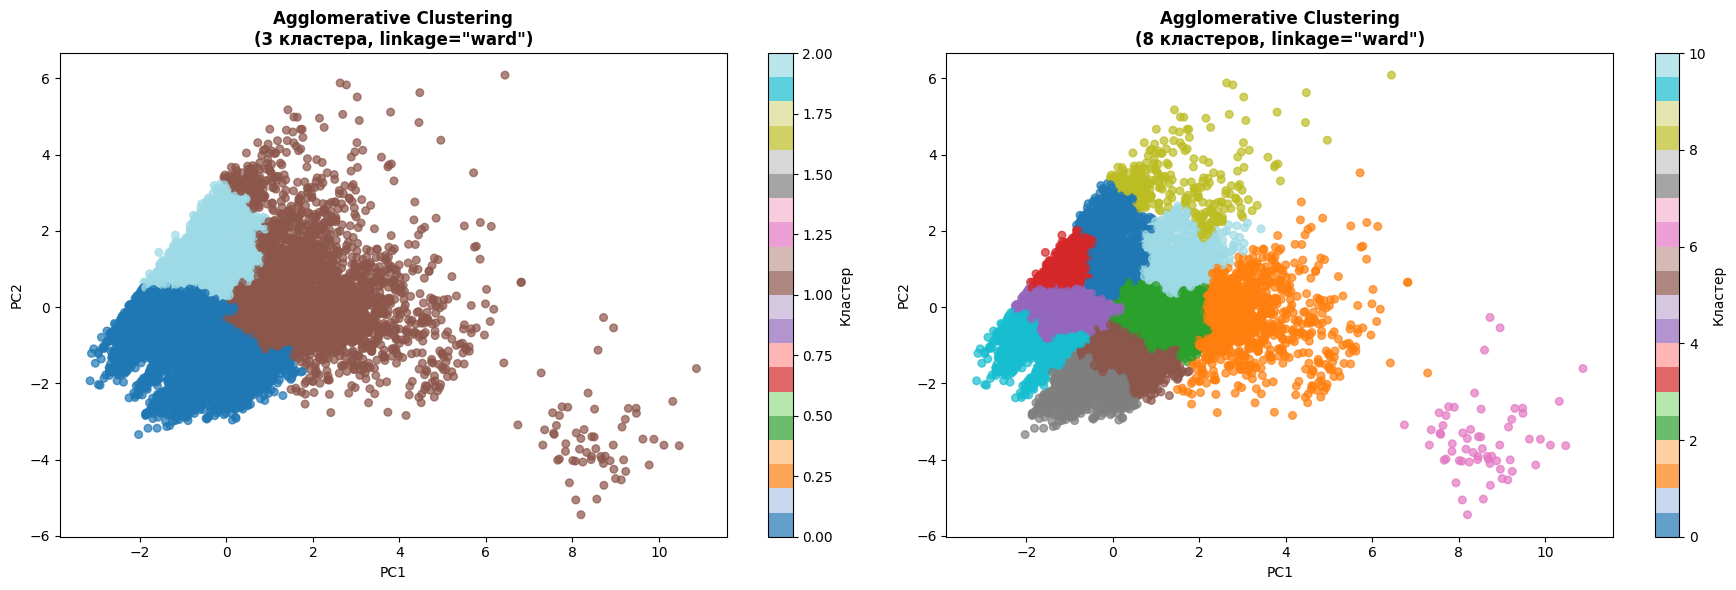

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Кластеризация Agglomerative Clustering с разным числом кластеров
agglo3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
agglo_labels3 = agglo3.fit_predict(X_pca)

agglo8 = AgglomerativeClustering(n_clusters=8, linkage='ward')
agglo_labels8 = agglo11.fit_predict(X_pca)

# Анализ результатов
print("=== Анализ Agglomerative Clustering ===")
print(f"Кластеризация с 3 кластерами:")
print(f"  - Уникальные метки: {np.unique(agglo_labels3)}")
print(f"  - Размеры кластеров: {np.bincount(agglo_labels3)}")
print(f"  - Доли: {np.bincount(agglo_labels3) / len(agglo_labels3)}")

print(f"\nКластеризация с 8 кластерами:")
print(f"  - Уникальные метки: {np.unique(agglo_labels8)}")
print(f"  - Размеры кластеров: {np.bincount(agglo_labels8)}")
print(f"  - Минимальный размер: {np.min(np.bincount(agglo_labels8))}")
print(f"  - Максимальный размер: {np.max(np.bincount(agglo_labels8))}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels3,
                          cmap='tab20', alpha=0.7, s=30)
axes[0].set_title('Agglomerative Clustering\n(3 кластера, linkage="ward")',
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels8,
                          cmap='tab20', alpha=0.7, s=30)
axes[1].set_title('Agglomerative Clustering\n(8 кластеров, linkage="ward")',
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()

Кластеризация не показала высоких результатов, но аналогичная ситуация была и с нейронной сетью, обученной на данном датасете.